# 图像金字塔

### 目标

在本章中，
- 我们将学习图像金字塔
- 我们将使用图像金字塔创建一个新的水果“Orapple”
- 我们将看到以下功能：**cv.pyrUp**()，**cv.pyrDown**()

## 理论

通常，我们过去使用的是恒定大小的图像。但是在某些情况下，我们需要使用不同分辨率的（相同）图像。例如，当在图像中搜索某些东西（例如人脸）时，我们不确定对象将以多大的尺寸显示在图像中。在这种情况下，我们将需要创建一组具有不同分辨率的相同图像，并在所有图像中搜索对象。这些具有不同分辨率的图像集称为“**图像金字塔**”（因为当它们堆叠在底部时，最高分辨率的图像位于顶部，最低分辨率的图像位于顶部时，看起来像金字塔）。

有两种图像金字塔。1）**高斯金字塔**和2）**拉普拉斯金字塔**

高斯金字塔中的较高级别（低分辨率）是通过删除较低级别（较高分辨率）图像中的连续行和列而形成的。然后，较高级别的每个像素由基础级别的5个像素的贡献与高斯权重形成。通过这样做，$M×N$图像变成$M/2 × N/2$图像。因此面积减少到原始面积的四分之一。它称为Octave。当我们在金字塔中越靠上时（即分辨率下降），这种模式就会继续。同样，在扩展时，每个级别的面积变为4倍。我们可以使用**cv.pyrDown**()和**cv.pyrUp**()函数找到高斯金字塔。

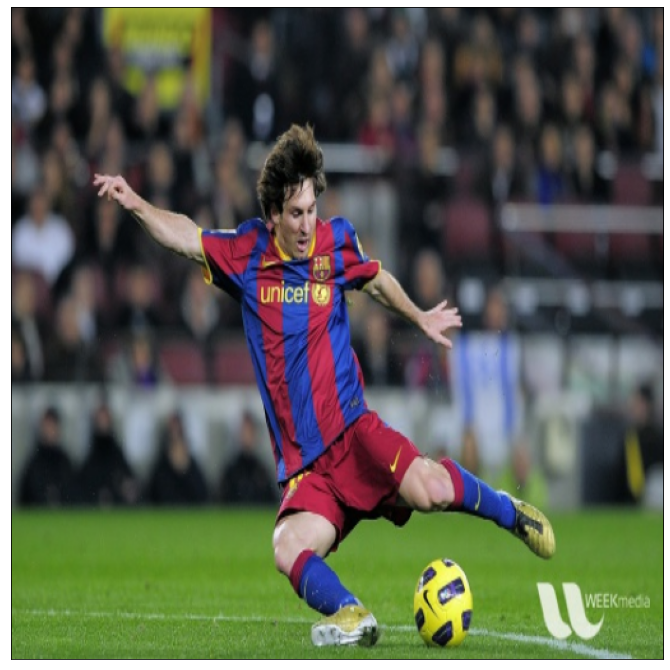

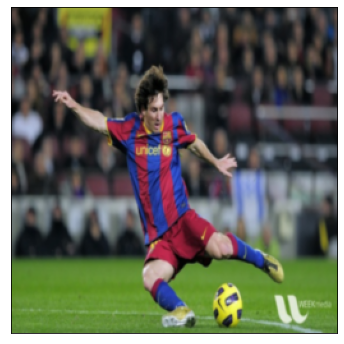

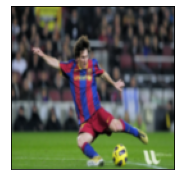

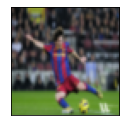

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('data/messi5.jpg')

img = cv.resize(img, dsize=(512, 512))

G = img.copy()
gp = [G]
sz = [(16, 12), (8, 6), (4, 3), (2, 2)]

for i in range(3):
    G = cv.pyrDown(G)
    gp.append(G)

for i in range(4):
    plt.figure(figsize=sz[i])
    plt.imshow(cv.cvtColor(gp[i], cv.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])

plt.show()

以上是图像金字塔中的4个级别。

现在，您可以使用**cv.pyrUp**()函数查看图像金字塔。

记住，higher不等于gp[2]，因为一旦降低了分辨率，就会丢失信息。下面的图像是3层的金字塔从最小的图像在前面的情况下创建。

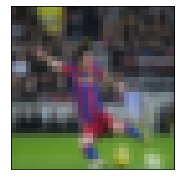

In [2]:
higher = cv.pyrDown(gp[3])

plt.figure(figsize=(4, 3))
plt.imshow(cv.cvtColor(higher, cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

拉普拉斯金字塔由高斯金字塔形成。没有专用功能。拉普拉斯金字塔图像仅像边缘图像。它的大多数元素为零。它们用于图像压缩。拉普拉斯金字塔的层由高斯金字塔的层与高斯金字塔的高层的扩展版本之间的差形成。拉普拉斯等级的三个等级如下所示（调整对比度以增强内容）：

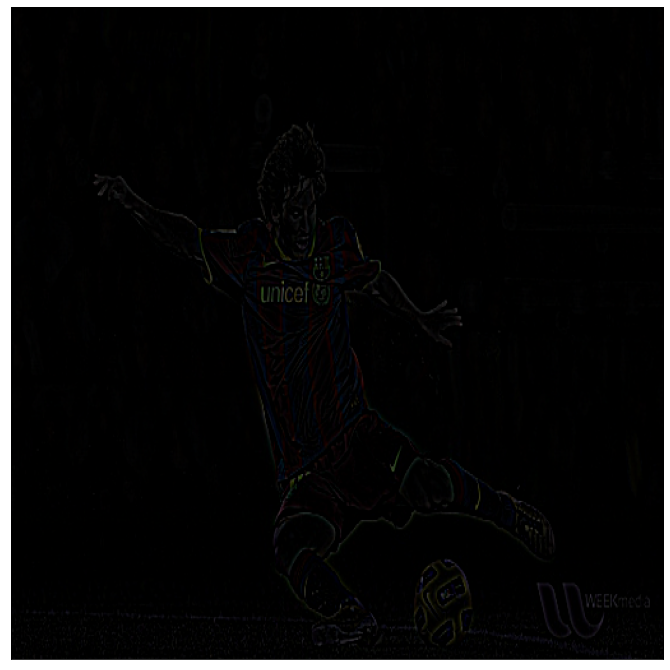

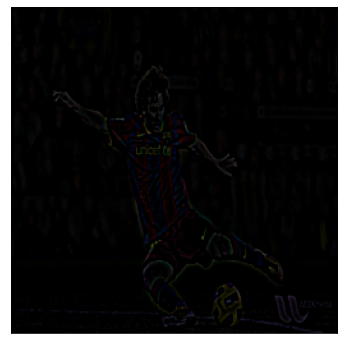

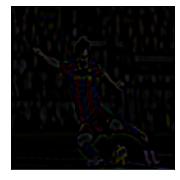

In [3]:
lp = [gp[3]]
for i in range(3,0,-1):
    GE = cv.pyrUp(gp[i])
    L = cv.subtract(gp[i-1],GE)
    lp.append(L)

for i in range(3,0, -1):
    plt.figure(figsize=sz[3-i])
    plt.imshow(cv.cvtColor(lp[i], cv.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])

plt.show()

### 使用金字塔进行图像融合

金字塔的一种应用是图像融合。例如，在图像拼接中，您需要将两个图像堆叠在一起，但是由于图像之间的不连续性，可能看起来不太好。在这种情况下，使用金字塔混合图像可以无缝混合，而不会在图像中保留大量数据。一个经典的例子是将两种水果，橙和苹果混合在一起。

请检查其他资源中的第一个参考，它具有图像混合，拉普拉斯金字塔等的完整图解详细信息。只需完成以下步骤即可：

1. 加载苹果和橙子的两个图像
2. 查找苹果和橙子的高斯金字塔（在此示例中， 级别数为6）
3. 在高斯金字塔中，找到其拉普拉斯金字塔
4. 然后在每个拉普拉斯金字塔级别中加入苹果的左半部分和橙子的右半部分
5. 最后从此联合图像金字塔中重建原始图像。

下面是完整的代码。（为简单起见，每个步骤都是单独进行的，这可能会占用更多的内存。如果需要，可以对其进行优化）。

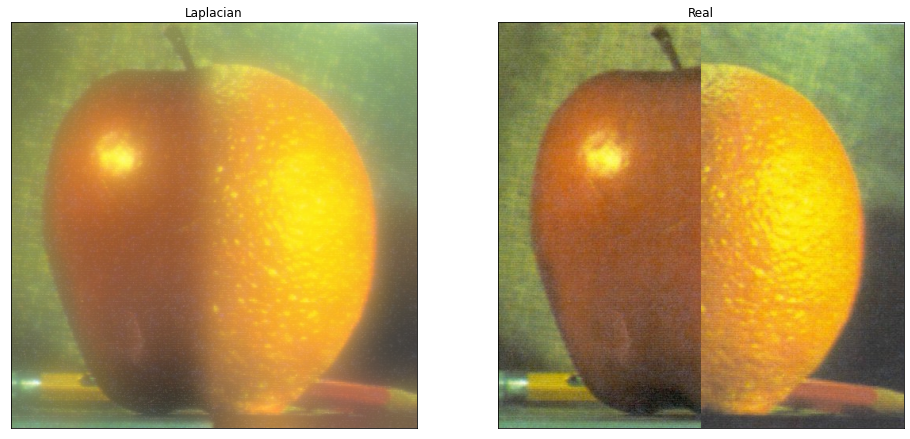

In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

A = cv.imread('data/apple.jpg')
B = cv.imread('data/orange.jpg')

# 生成A的高斯金字塔
G = A.copy()
gpA = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpA.append(G)

# 生成B的高斯金字塔
G = B.copy()
gpB = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpB.append(G)

# 生成A的拉普拉斯金字塔
lpA = [gpA[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpA[i])
    L = cv.subtract(gpA[i-1],GE)
    lpA.append(L)

# 生成B的拉普拉斯金字塔
lpB = [gpB[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpB[i])
    L = cv.subtract(gpB[i-1],GE)
    lpB.append(L)

# 现在在每个级别中添加左右两半图像 
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    ls = np.hstack((la[:,0:cols//2], lb[:,cols//2:]))
    LS.append(ls)

# 现在重建
ls_ = LS[0]
for i in range(1,6):
    ls_ = cv.pyrUp(ls_)
    ls_ = cv.add(ls_, LS[i])

# 图像与直接连接的每一半
real = np.hstack((A[:,:cols//2],B[:,cols//2:]))

cv.imwrite('output/Pyramid_blending2.jpg', ls_)
cv.imwrite('output/Direct_blending.jpg', real)

plt.figure(figsize=(16, 8))

plt.subplot(121),plt.imshow(cv.cvtColor(ls_, cv.COLOR_BGR2RGB)),plt.title('Laplacian')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cv.cvtColor(real, cv.COLOR_BGR2RGB)),plt.title('Real')
plt.xticks([]), plt.yticks([])

plt.show()

### 附加资源
1. Image Blending：http://pages.cs.wisc.edu/~csverma/CS766_09/ImageMosaic/imagemosaic.html

### 练习